In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")

In [2]:
from nnsight import LanguageModel
import torch.nn.functional as F
import torch as th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from pathlib import Path
from time import time
import itertools

# Fix logger bug
import babelnet
from nnsight import logger

logger.disabled = True

th.set_grad_enabled(False)

2024-05-22 20:23:30,547 [babelnet.conf] INFO: Loaded configuration from ['/dlabscratch1/cdumas/babelnet_conf.yml']
2024-05-22 20:23:30,550 [babelnet.api] INFO: BabelNet online RESTful API v1.2.0


In [3]:
model = "croissantllm/CroissantLLMBase"
model_path = None
check_translation_performance = False
batch_size = 64
thinking_langs = ["en", "fr"]
langs = ["en", "fr", "de", "ru", "zh"]
method = "logit_lens"
device = "auto"
trust_remote_code = False

In [4]:
del method  # Not used in this notebook
langs = np.array(langs)
out_langs = {lang: np.array([l for l in langs if l != lang]) for lang in langs}
if model_path is None:
    model_path = model
tokenizer_kwargs = dict(trust_remote_code=trust_remote_code, add_prefix_space=False)
nn_model = LanguageModel(
    model_path,
    device_map=device,
    torch_dtype=th.float16,
    trust_remote_code=trust_remote_code,
    tokenizer_kwargs=tokenizer_kwargs,
    dispatch=True,
)

2024-05-22 20:23:33,697 [accelerate.utils.modeling] INFO: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Plots

In [16]:
from exp_tools import run_prompts, TargetPromptBatch, patchscope_lens
from translation_tools import translation_prompts

from translation_tools import get_bn_dataset as get_translations
from random import sample

# from translation_tools import get_gpt4_dataset as get_translations
from utils import plot_ci, ulist, plot_k, plot_topk_tokens


def cross_translation_plot(
    source_input_lang,
    source_target_lang,
    input_lang,
    target_lang,
    extra_langs=None,
    batch_size=batch_size,
    num_words=None,
    ax=None,
    time_=None,
    k=4,
):
    """
    Patchscope with source hidden from:
    index -1 and Prompt = source_input_lang: A -> source_target_lang:
    Into target prompt:
    into index = -1, prompt = input_lang: A -> target_lang:
    Then plot with latent_langs, target_lang, source_target_lang
    """
    if extra_langs is None:
        extra_langs = []
    if isinstance(extra_langs, str):
        extra_langs = [extra_langs]
    model_name = model.split("/")[-1]
    global source_df, target_df, target_prompts, target_probs, latent_probs, source_prompts
    if time_ is None:
        time_ = str(int(time()))
    else:
        time_ = str(time_)
    if isinstance(extra_langs, str):
        extra_langs = [extra_langs]
    source_df = get_translations(
        source_input_lang,
        [source_target_lang, input_lang, target_lang, *extra_langs],
    )
    target_df = get_translations(
        input_lang,
        [source_target_lang, source_input_lang, target_lang, *extra_langs],
    )
    # Keep rows which word_original is in both dataframes
    merge = pd.merge(
        source_df.reset_index(),
        target_df.reset_index(),
        on="word_original",
        how="inner",
        suffixes=("_source", "_target"),
    )
    if num_words is not None:
        merge = merge.sample(num_words)
    source_df = source_df.iloc[merge["index_source"]]
    target_df = target_df.iloc[merge["index_target"]]
    extra_langs = ulist(
        [
            source_input_lang,
            source_target_lang,
            *extra_langs,
        ]
    )

    source_prompts = translation_prompts(
        source_df, nn_model.tokenizer, source_input_lang, source_target_lang, []
    )

    target_prompts = translation_prompts(
        target_df, nn_model.tokenizer, input_lang, target_lang, extra_langs
    )
    assert len(source_prompts) == len(
        target_prompts
    ), f"Prompts have different lengths: {len(source_prompts)} and {len(target_prompts)}"
    source_prompts_str = [p.prompt for p in source_prompts]

    def transverse_patchscope(nn_model, prompt_batch, scan):
        offset = transverse_patchscope.offset
        target_pathscope_prompts = TargetPromptBatch.from_prompts(prompt_batch, -1)
        source_prompt_batch = source_prompts_str[offset : offset + len(prompt_batch)]
        transverse_patchscope.offset += len(prompt_batch)
        return patchscope_lens(
            nn_model, source_prompt_batch, target_pathscope_prompts, scan=scan
        )

    transverse_patchscope.offset = 0
    target_probs, latent_probs = run_prompts(
        nn_model, target_prompts, batch_size=batch_size, method=transverse_patchscope
    )

    # Get the baseline to normalize the plots
    source_prompts_probs, _ = run_prompts(
        nn_model, source_prompts, batch_size=batch_size, method="next_token_probs"
    )
    source_prompts_baseline = source_prompts_probs.mean()
    target_prompts_probs, _ = run_prompts(
        nn_model, target_prompts, batch_size=batch_size, method="next_token_probs"
    )
    target_prompts_baseline = target_prompts_probs.mean()

    json_dic = {
        target_lang: target_probs.tolist(),
        "source_prompt_baseline": source_prompts_probs.squeeze().tolist(),
        "target_prompt_baseline": target_prompts_probs.squeeze().tolist(),
    }
    for label, probs in latent_probs.items():
        json_dic[label] = probs.tolist()
    path = (
        Path("results")
        / model_name
        / "cross_translation"
        / (
            f"{source_input_lang}_{source_target_lang}-{input_lang}_{target_lang}-"
            + "_".join(extra_langs[2:])
        )
    )
    path.mkdir(parents=True, exist_ok=True)
    json_file = path / (time_ + ".json")
    with open(json_file, "w") as f:
        json.dump(json_dic, f, indent=4)
    if ax is None:
        fig, ax = plt.subplots()
    colors = sns.color_palette("tab10", 1 + len(extra_langs))
    plot_ci(
        ax, target_probs / target_prompts_baseline, label=target_lang, color=colors[0]
    )
    for i, (label, probs) in enumerate(latent_probs.items()):
        baseline = 1
        if label == source_target_lang:
            baseline = source_prompts_baseline
        else:
            if label == source_input_lang:
                baseline = source_prompts_baseline
            if label == input_lang:
                baseline = min(baseline, target_prompts_baseline)
        plot_ci(ax, probs / baseline, label=label, color=colors[i + 1], init=False)
    ax.legend()
    title = f"{model_name}: Patchscope from ({source_input_lang} -> {source_target_lang}) into ({input_lang} -> {target_lang})"
    ax.set_title(title)
    # Save the plot
    plot_file = path / (time_ + ".png")
    plt.savefig(plot_file, dpi=300, bbox_inches="tight")
    plt.show()
    # change the size
    fig, axes = plt.subplots(1, k, figsize=(5 * k, 5))
    idx = th.randperm(len(source_prompts_str))[:k]
    plot_k(
        axes,
        target_probs[idx],
        label=target_lang,
        color=colors[0],
        k=k,
    )
    for i, (label, probs) in enumerate(latent_probs.items()):
        plot_k(
            axes,
            probs[idx],
            label=label,
            color=colors[i + 1],
            init=False,
            k=k,
        )
    axes[-1].legend()
    fig.suptitle(title + " - Raw probabilities")
    plt_file = path / (time_ + "_k.png")
    fig.savefig(plt_file, dpi=300, bbox_inches="tight")
    fig.show()
    json_meta = {}
    for i in idx:
        json_meta[i.item()] = {
            "source input lang": source_input_lang,
            "source target lang": source_target_lang,
            "input lang": input_lang,
            "target lang": target_lang,
            "source prompt": source_prompts_str[i],
            "source prompt target": source_prompts[i].target_string,
            "target prompt": target_prompts[i].prompt,
            "target prompt target": target_prompts[i].target_string,
            "target prompt latent": target_prompts[i].latent_strings,
        }
    json_df = pd.DataFrame(json_meta)
    with pd.option_context(
        "display.max_colwidth",
        None,
        "display.max_columns",
        None,
        "display.max_rows",
        None,
    ):
        display(json_df)
    target_prompt_batch = TargetPromptBatch.from_prompts(
        [target_prompts[i].prompt for i in idx], -1
    )
    probs = patchscope_lens(
        nn_model, [source_prompts_str[i] for i in idx], target_prompt_batch
    )
    file = path / (time_ + "_heatmap.png")
    plot_topk_tokens(probs, nn_model, title=title, file=file)

    meta_file = path / (time_ + "_heatmap.meta.json")
    with open(meta_file, "w") as f:
        json.dump(json_meta, f, indent=4)

In [14]:
time_ = int(time())
print(f"Experiment time id: {time_}")

Experiment time id: 1716409792


Running prompts:   0%|          | 0/6 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/6 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/6 [00:00<?, ?it/s]

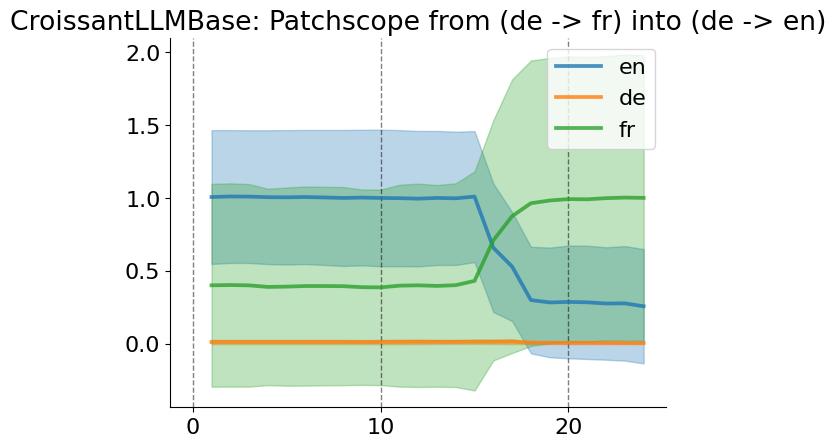

,3,5,0,2
source input lang,de,de,de,de
source target lang,fr,fr,fr,fr
input lang,de,de,de,de
target lang,en,en,en,en
source prompt,"Deutsch: ""Wolke"" - Français: ""nuage""\nDeutsch: ""Herz"" - Français: ""cœur""\nDeutsch: ""Feuer"" - Français: ""flamme""\nDeutsch: ""Feld"" - Français: ""plaine""\nDeutsch: ""Straße"" - Français: ""route""\nDeutsch: ""Mutter"" - Français: ""","Deutsch: ""Feuer"" - Français: ""flamme""\nDeutsch: ""Straße"" - Français: ""route""\nDeutsch: ""Mutter"" - Français: ""maman""\nDeutsch: ""Wolke"" - Français: ""nuage""\nDeutsch: ""Herz"" - Français: ""cœur""\nDeutsch: ""Feld"" - Français: ""","Deutsch: ""Feld"" - Français: ""plaine""\nDeutsch: ""Straße"" - Français: ""route""\nDeutsch: ""Feuer"" - Français: ""flamme""\nDeutsch: ""Mutter"" - Français: ""maman""\nDeutsch: ""Wolke"" - Français: ""nuage""\nDeutsch: ""Herz"" - Français: ""","Deutsch: ""Herz"" - Français: ""cœur""\nDeutsch: ""Straße"" - Français: ""route""\nDeutsch: ""Feld"" - Français: ""plaine""\nDeutsch: ""Mutter"" - Français: ""maman""\nDeutsch: ""Feuer"" - Français: ""flamme""\nDeutsch: ""Wolke"" - Français: """
source prompt target,"[maman, maternité, mère, écrou]","[plaine, champ]","[cœur, myocarde, cœur humain, cavité cardiaque, Philia, affection, philia]",[nuage]
target prompt,"Deutsch: ""Wolke"" - English: ""cloud""\nDeutsch: ""Straße"" - English: ""road""\nDeutsch: ""Feuer"" - English: ""flame""\nDeutsch: ""Herz"" - English: ""heart""\nDeutsch: ""Feld"" - English: ""plain""\nDeutsch: ""Mutter"" - English: ""","Deutsch: ""Herz"" - English: ""heart""\nDeutsch: ""Straße"" - English: ""road""\nDeutsch: ""Feuer"" - English: ""flame""\nDeutsch: ""Wolke"" - English: ""cloud""\nDeutsch: ""Mutter"" - English: ""mother""\nDeutsch: ""Feld"" - English: ""","Deutsch: ""Straße"" - English: ""road""\nDeutsch: ""Feld"" - English: ""plain""\nDeutsch: ""Feuer"" - English: ""flame""\nDeutsch: ""Wolke"" - English: ""cloud""\nDeutsch: ""Mutter"" - English: ""mother""\nDeutsch: ""Herz"" - English: ""","Deutsch: ""Straße"" - English: ""road""\nDeutsch: ""Herz"" - English: ""heart""\nDeutsch: ""Feld"" - English: ""plain""\nDeutsch: ""Mutter"" - English: ""mother""\nDeutsch: ""Feuer"" - English: ""flame""\nDeutsch: ""Wolke"" - English: """
target prompt target,"[mother, female parent, motherhood, mom, mammy, mama, mummy, mum, ma, momma, mamma, mumma, mommy, nut]","[plain, champaign, field, acre]","[heart, ticker, pump, Diaphragmatic surface of heart, human heart, cardiac chamber, affectionateness, philia, fondness, warmheartedness, affection, tenderness, warmness, affectio]",[cloud]
target prompt latent,"{'de': ['Mutter', 'Mutterschaft', 'Schraubenmutter'], 'fr': ['maman', 'maternité', 'mère', 'écrou']}","{'de': ['Feld', 'Ebene', 'Acker', 'Anbaufläche', 'Ackergrund', 'landwirtschaftliche Nutzfläche', 'Ackerland', 'Weide', 'Esch', 'Flur', 'Weideland', 'Trade'], 'fr': ['plaine', 'champ']}","{'de': ['Herz', 'Philia', 'Affektion', 'Zuneigung'], 'fr': ['cœur', 'myocarde', 'cœur humain', 'cavité cardiaque', 'Philia', 'affection', 'philia']}","{'de': ['Wolke', 'Gewölk'], 'fr': ['nuage']}"


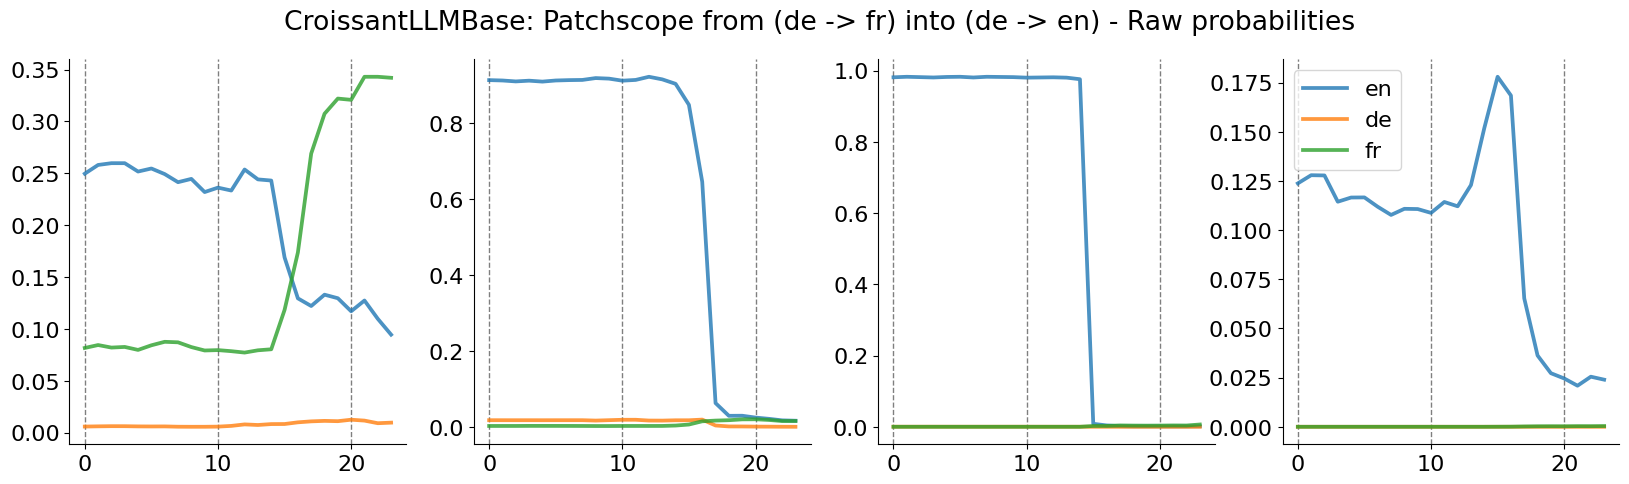

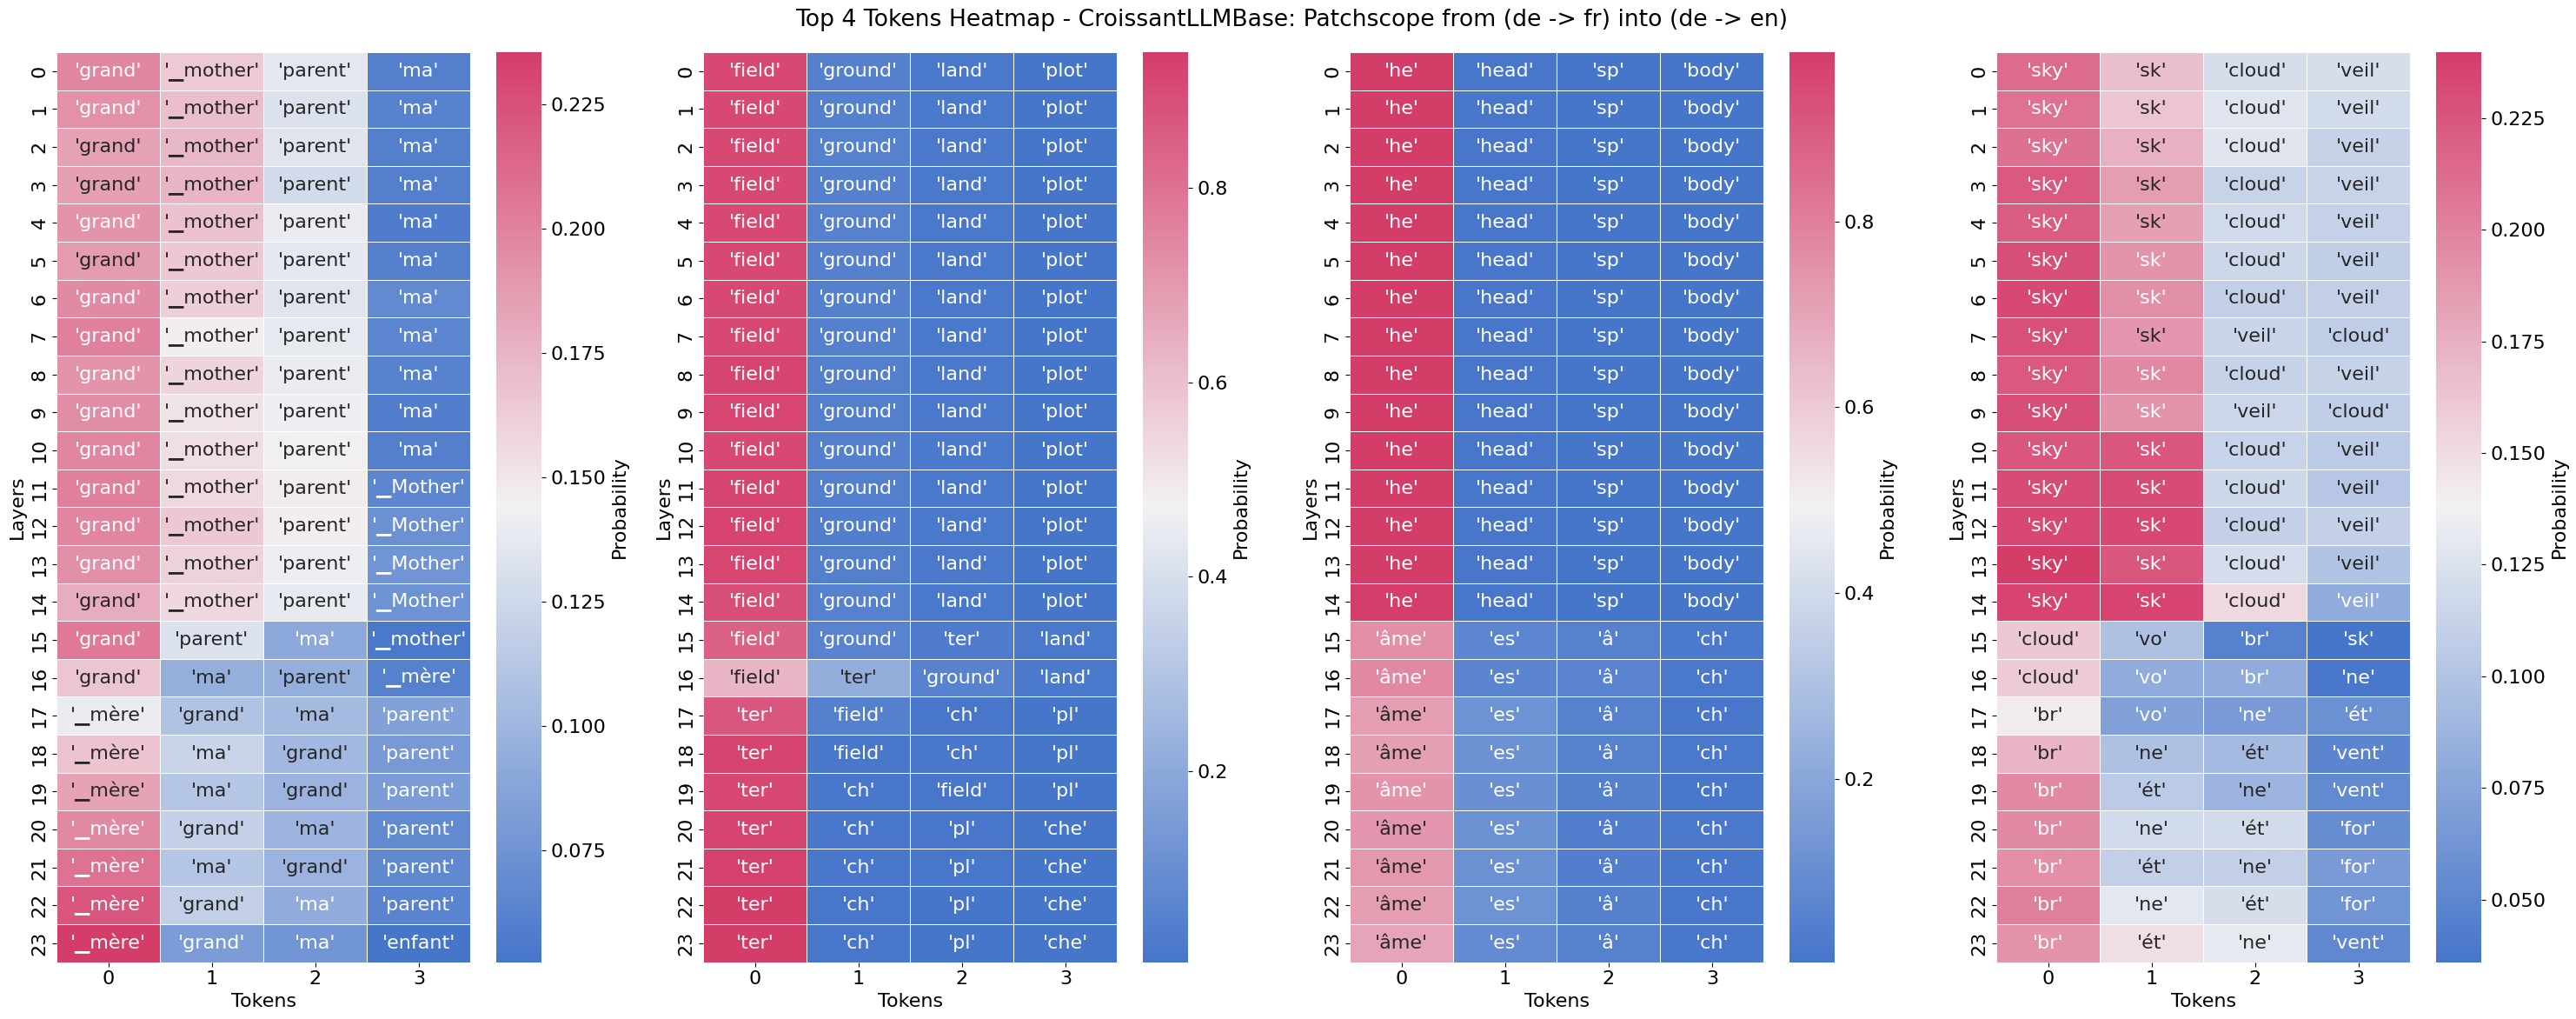

In [17]:
for source_input_lang in langs:
    for source_target_lang in out_langs[source_input_lang]:
        for in_lang in langs:
            for out_lang in out_langs[in_lang]:
                if source_input_lang == in_lang and source_target_lang == out_lang:
                    continue
                cross_translation_plot(
                    source_input_lang,
                    source_target_lang,
                    in_lang,
                    out_lang,
                    thinking_langs,
                    time_=time_,
                )